In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import os
import pickle
from datetime import datetime as dt
%matplotlib inline

import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

categorical = []
NFOLDS = 3
Seedarray = range(NFOLDS)

In [13]:
def rmse(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power((y - y0), 2)))

def get_lgb_model(Dtrain, Dvalid, param=None, numiter=1500, isValid=True, randomseed=0):
    lgbm_params = {'task': 'train',
                    'boosting_type': 'gbdt',
                    'objective': 'regression',
                    'metric': 'rmse',
                    #'max_depth': 15,
                    'num_leaves': 270,
                    'feature_fraction': 0.5,
                    'bagging_fraction': 0.75,
                    'bagging_freq': 2,
                    'learning_rate': 0.016,
                    'max_bin': 255,
                    'seed': randomseed
                  }
    lgbm_params.update(param)
    evals_results = {}
    # Train lgb
    if isValid == True:
        lgb_clf = lgb.train(lgbm_params,
                            Dtrain,
                            valid_sets=[Dvalid],
                            valid_names=['valid'],
                            num_boost_round=numiter,
                            early_stopping_rounds=50,
                            verbose_eval=50,
                            evals_result=evals_results,
                            feval=None
                           )
    else:
        lgb_clf = lgb.train(lgbm_params,
                            Dtrain,
                            valid_sets=[Dvalid],
                            valid_names=['valid'],
                            num_boost_round=numiter,
                            verbose_eval=100,
                            feval=None
                           )
    # Plot importances
    lgb.plot_importance(lgb_clf, importance_type="split", title="split", figsize=(16, 16))
    plt.show()
    lgb.plot_importance(lgb_clf, importance_type="gain", title='gain', figsize=(16, 16))
    plt.show()

    best_iteration = lgb_clf.best_iteration
    print(f'best iteration is {best_iteration}')
    if isValid:
        best_score = evals_results['valid']['rmse'][lgb_clf.best_iteration-1]
        print(f'best score is {best_score}')
    return lgb_clf, best_iteration

def get_lgb_train(trainX, trainy, validX, validy, predictors, categorical):
    Dtrain = lgb.Dataset(trainX.values, label=trainy.values.ravel(), feature_name=predictors, categorical_feature=categorical)
    Dvalid = lgb.Dataset(validX.values, label=validy.values.ravel(), feature_name=predictors, categorical_feature=categorical)
    return Dtrain, Dvalid


In [11]:
# Example For KFold
EnableSubmit = False
NFOLDS = 3
numiter = 500

# DODODODODODO
train = pd.read_feather('../features/train/Agg_by_Itemseq_median_1_train.feather')
temptrain = pd.read_feather('../features/train/Agg_by_Itemseq_median_2_train.feather')
train = pd.concat([train, temptrain], axis=1)
temptrain = pd.read_feather('../features/train/Agg_by_Itemseq_median_3_train.feather')
train = pd.concat([train, temptrain], axis=1)
temptrain = pd.read_feather('../features/train/Agg_by_Itemseq_median_4_train.feather')
train = pd.concat([train, temptrain], axis=1)
del temptrain; gc.collect()
y = pd.read_csv('../input/train.csv', usecols=['deal_probability'])

kf = KFold(n_splits=NFOLDS)
lgb_models = []
best_iters = []
feature_imp_split = []
feature_imp_gain = []
preds = pd.DataFrame()
print(train.shape)
print(y.shape)
predictors = train.columns.tolist()

for count, indices in enumerate(kf.split(train, y)):
    train_idx = indices[0]
    valid_idx = indices[1]
    Dtrain, Dvalid = get_lgb_train(train.iloc[train_idx,:], y.iloc[train_idx,:], train.iloc[valid_idx,:], y.iloc[valid_idx,:], predictors, categorical)
    del train, y; gc.collect()
    lgb_model, bestiter = get_lgb_model(Dtrain, Dvalid, numiter=numiter, isValid=True, randomseed=76)
    del Dtrain, Dvalid; gc.collect()

    # DODODODO
    if EnableSubmit == True:
        test = pd.read_csv('./hofe')
        preds['lgb_pred_kfold_'+str(count)] = lgb_model.predict(test[predictors], num_iteration=best_iter)
        del test; gc.collect()
    
    lgb_models.append(lgb_model)
    best_iters.append(bestiter)
    fcols = lgb_model.feature_name()
    fimps = lgb_model.feature_importance(importance_type='split')
    feature_imp_split.append({fcol: fimp for fimp, fcol in zip(fimps, fcols)})
    fimps = lgb_model.feature_importance(importance_type='gain')
    feature_imp_gain.append({fcol: fimp for fimp, fcol in zip(fimps, fcols)})
    
    # DODDODODOO
    train = pd.read_feather('../features/train/Agg_by_Itemseq_median_1_train.feather')
    temptrain = pd.read_feather('../features/train/Agg_by_Itemseq_median_2_train.feather')
    train = pd.concat([train, temptrain], axis=1)
    temptrain = pd.read_feather('../features/train/Agg_by_Itemseq_median_3_train.feather')
    train = pd.concat([train, temptrain], axis=1)
    temptrain = pd.read_feather('../features/train/Agg_by_Itemseq_median_4_train.feather')
    train = pd.concat([train, temptrain], axis=1)
    del temptrain; gc.collect()
    y = pd.read_csv('../input/train.csv', usecols=['deal_probability'])

del train, y
gc.collect()

print('Best iterations:')
print(best_iters)
#print('Feature Importtance Split')
#print(feature_imp_split)
#print('Feature Importtance Gain')
#print(feature_imp_gain)

datetime = dt.now().strftime('%Y_%m%d_%H%M_%S')
fileprefix = '../subs/lightgbm_kfold_ensemble_'

if EnableSubmit == True:
    subs = pd.read_csv('../input/test.csv', usecols=['item_id'])

    pred_ensemble = np.zeros_like(preds['lgb_pred_kfold_0'].values)
    for col in preds.columns:
        pred_ensemble += preds[col].values
    pred_ensemble /= np.float(NFOLDS)
    pred_ensemble = np.clip(pred_ensemble, 0, 1)
    subs['deal_probability'] = pred_ensemble.flatten()


    filename = fileprefix+datetime+'.csv.gz'
    subs.to_csv(filename, index=False, float_format='%.9f', compression='gzip')

    del subs; gc.collect()
#del lgb_models, best_iters, feature_imp_split, feature_imp_gain; gc.collect()


ArrowIOError: Failed to open local file: ../features/train/Agg_by_Itemseq_median_1_train.feather , error: No such file or directory

(1503424, 162)
(1503424, 1)


C:\Users\osk\Anaconda3\envs\InqueryAnalysis\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[100]	valid's rmse: 0.109207
[200]	valid's rmse: 0.11288
[300]	valid's rmse: 0.113828
[400]	valid's rmse: 0.113739
[500]	valid's rmse: 0.113237


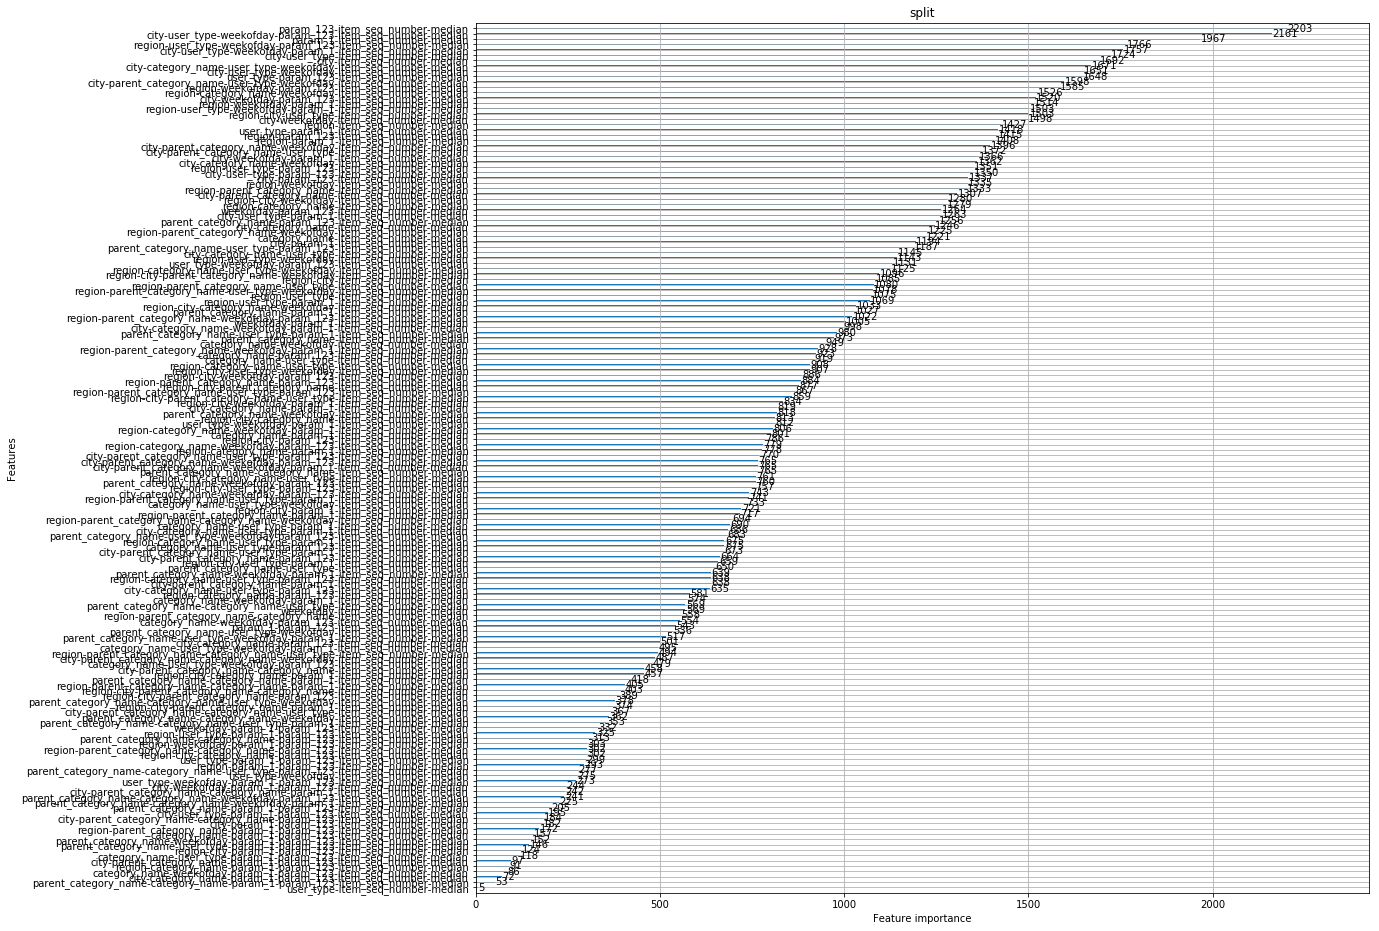

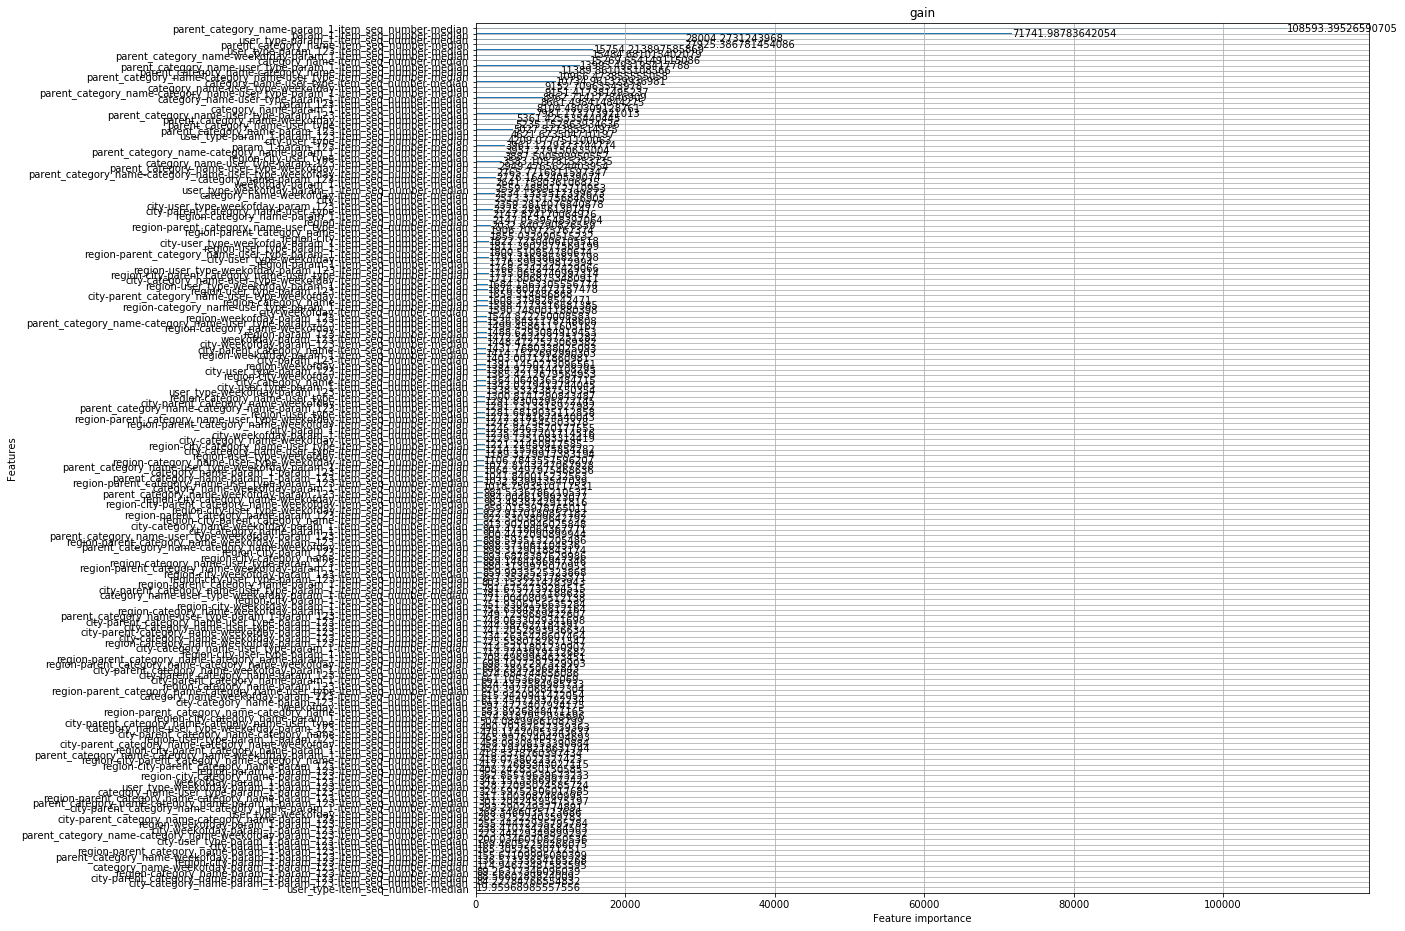

best iteration is 0


In [4]:
# Example For whole traindata
EnableSubmit = False
numiter = 500

# DODODDODO
train = pd.read_feather('../features/train/Agg_by_Itemseq_median_1_train.feather')
temptrain = pd.read_feather('../features/train/Agg_by_Itemseq_median_2_train.feather')
train = pd.concat([train, temptrain], axis=1)
temptrain = pd.read_feather('../features/train/Agg_by_Itemseq_median_3_train.feather')
train = pd.concat([train, temptrain], axis=1)
temptrain = pd.read_feather('../features/train/Agg_by_Itemseq_median_4_train.feather')
train = pd.concat([train, temptrain], axis=1)
del temptrain; gc.collect()
y = pd.read_csv('../input/train.csv', usecols=['deal_probability'])
predictors = train.columns.tolist()
print(train.shape)
print(y.shape)

Dtrain, Dvalid = get_lgb_train(train, y, train.iloc[:2, :], y.iloc[:2, :], predictors, categorical)
del train, y; gc.collect()
lgb_model, best_iter = get_lgb_model(Dtrain, Dvalid, numiter=numiter, isValid=False, randomseed=98)
del Dtrain; gc.collect()

feature_imp_split = []
feature_imp_gain = []
fcols = lgb_model.feature_name()
fimps = lgb_model.feature_importance(importance_type='split')
feature_imp_split.append({fcol: fimp for fimp, fcol in zip(fimps, fcols)})
fimps = lgb_model.feature_importance(importance_type='gain')
feature_imp_gain.append({fcol: fimp for fimp, fcol in zip(fimps, fcols)})

#print('Feature Importtance Split')
#print(feature_imp_split)
#print('Feature Importtance Gain')
#print(feature_imp_gain)

datetime = dt.now().strftime('%Y_%m%d_%H%M_%S')
fileprefix = '../subs/lightgbm_kfold_ensemble_'

if EnableSubmit == True:
    subs = pd.read_csv('../input/test.csv', usecols=['item_id'])
    # DODODDODODODO
    test = get_test_forlgb('../features/featured/test/hoge.feather')
    subs['deal_probability'] = lgb_model.predict(test[predictors], num_iteration=best_iter)

    filename = fileprefix+datetime+'.csv.gz'
    subs.to_csv(filename, index=False, float_format='%.9f', compression='gzip')
    del subs, test; gc.collect()

#del feature_imp_split, feature_imp_gain, lgb_model

In [5]:
len(feature_imp_gain[0])
len(feature_imp_split[0])

sort_gain = sorted(feature_imp_gain[0].items(), key=lambda x: -x[1])
for k, _ in sort_gain[:5]:
    print(k)

sort_split = sorted(feature_imp_split[0].items(), key=lambda x: -x[1])
for k, _ in sort_split[:5]:
    print(k)

parent_category_name-param_1-item_seq_number-median
param_1-item_seq_number-median
user_type-param_1-item_seq_number-median
parent_category_name-item_seq_number-median
user_type-param_123-item_seq_number-median
param_123-item_seq_number-median
city-user_type-weekofday-param_123-item_seq_number-median
param_1-item_seq_number-median
region-user_type-weekofday-param_123-item_seq_number-median
city-user_type-weekofday-param_1-item_seq_number-median


In [6]:
gainlist = [k for k, _ in sort_gain[:14]]
splitlist = [k for k, _ in sort_split[:14]]

label_set = set(gainlist+splitlist)
print(len(label_set))
print(label_set)

26
{'region-category_name-weekofday-item_seq_number-median', 'city-user_type-item_seq_number-median', 'city-user_type-weekofday-item_seq_number-median', 'user_type-param_1-item_seq_number-median', 'category_name-item_seq_number-median', 'city-parent_category_name-user_type-weekofday-item_seq_number-median', 'city-category_name-user_type-weekofday-item_seq_number-median', 'parent_category_name-user_type-param_1-item_seq_number-median', 'parent_category_name-category_name-user_type-param_1-item_seq_number-median', 'parent_category_name-weekofday-param_1-item_seq_number-median', 'region-user_type-weekofday-param_123-item_seq_number-median', 'category_name-user_type-item_seq_number-median', 'user_type-param_123-item_seq_number-median', 'parent_category_name-param_1-item_seq_number-median', 'category_name-user_type-weekofday-item_seq_number-median', 'category_name-user_type-param_1-item_seq_number-median', 'city-weekofday-param_123-item_seq_number-median', 'parent_category_name-item_seq_num

In [7]:
# 分解する
label_list = list(label_set)
label_list = [k[:-7] for k in label_list]
for k in label_list:
    print(k)

region-category_name-weekofday-item_seq_number
city-user_type-item_seq_number
city-user_type-weekofday-item_seq_number
user_type-param_1-item_seq_number
category_name-item_seq_number
city-parent_category_name-user_type-weekofday-item_seq_number
city-category_name-user_type-weekofday-item_seq_number
parent_category_name-user_type-param_1-item_seq_number
parent_category_name-category_name-user_type-param_1-item_seq_number
parent_category_name-weekofday-param_1-item_seq_number
region-user_type-weekofday-param_123-item_seq_number
category_name-user_type-item_seq_number
user_type-param_123-item_seq_number
parent_category_name-param_1-item_seq_number
category_name-user_type-weekofday-item_seq_number
category_name-user_type-param_1-item_seq_number
city-weekofday-param_123-item_seq_number
parent_category_name-item_seq_number
param_1-item_seq_number
city-user_type-weekofday-param_1-item_seq_number
param_123-item_seq_number
parent_category_name-category_name-user_type-item_seq_number
city-user_t

In [8]:
label_splits = []
for k in label_list:
    label_splits.append(k.split('-'))

for k in label_splits:
    print(k)

['region', 'category_name', 'weekofday', 'item_seq_number']
['city', 'user_type', 'item_seq_number']
['city', 'user_type', 'weekofday', 'item_seq_number']
['user_type', 'param_1', 'item_seq_number']
['category_name', 'item_seq_number']
['city', 'parent_category_name', 'user_type', 'weekofday', 'item_seq_number']
['city', 'category_name', 'user_type', 'weekofday', 'item_seq_number']
['parent_category_name', 'user_type', 'param_1', 'item_seq_number']
['parent_category_name', 'category_name', 'user_type', 'param_1', 'item_seq_number']
['parent_category_name', 'weekofday', 'param_1', 'item_seq_number']
['region', 'user_type', 'weekofday', 'param_123', 'item_seq_number']
['category_name', 'user_type', 'item_seq_number']
['user_type', 'param_123', 'item_seq_number']
['parent_category_name', 'param_1', 'item_seq_number']
['category_name', 'user_type', 'weekofday', 'item_seq_number']
['category_name', 'user_type', 'param_1', 'item_seq_number']
['city', 'weekofday', 'param_123', 'item_seq_numbe

In [9]:
with open('./Golden_Itemseq_median_agg.pickle', 'wb') as f:
    pickle.dump(label_splits, f)
    

(1503424, 26)
(1503424, 1)


C:\Users\osk\Anaconda3\envs\InqueryAnalysis\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds.
[50]	valid's rmse: 0.239227
[100]	valid's rmse: 0.234516
[150]	valid's rmse: 0.233407
[200]	valid's rmse: 0.233081
[250]	valid's rmse: 0.232954
[300]	valid's rmse: 0.232893
[350]	valid's rmse: 0.232851
[400]	valid's rmse: 0.232817
[450]	valid's rmse: 0.232797
[500]	valid's rmse: 0.232783
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.232781


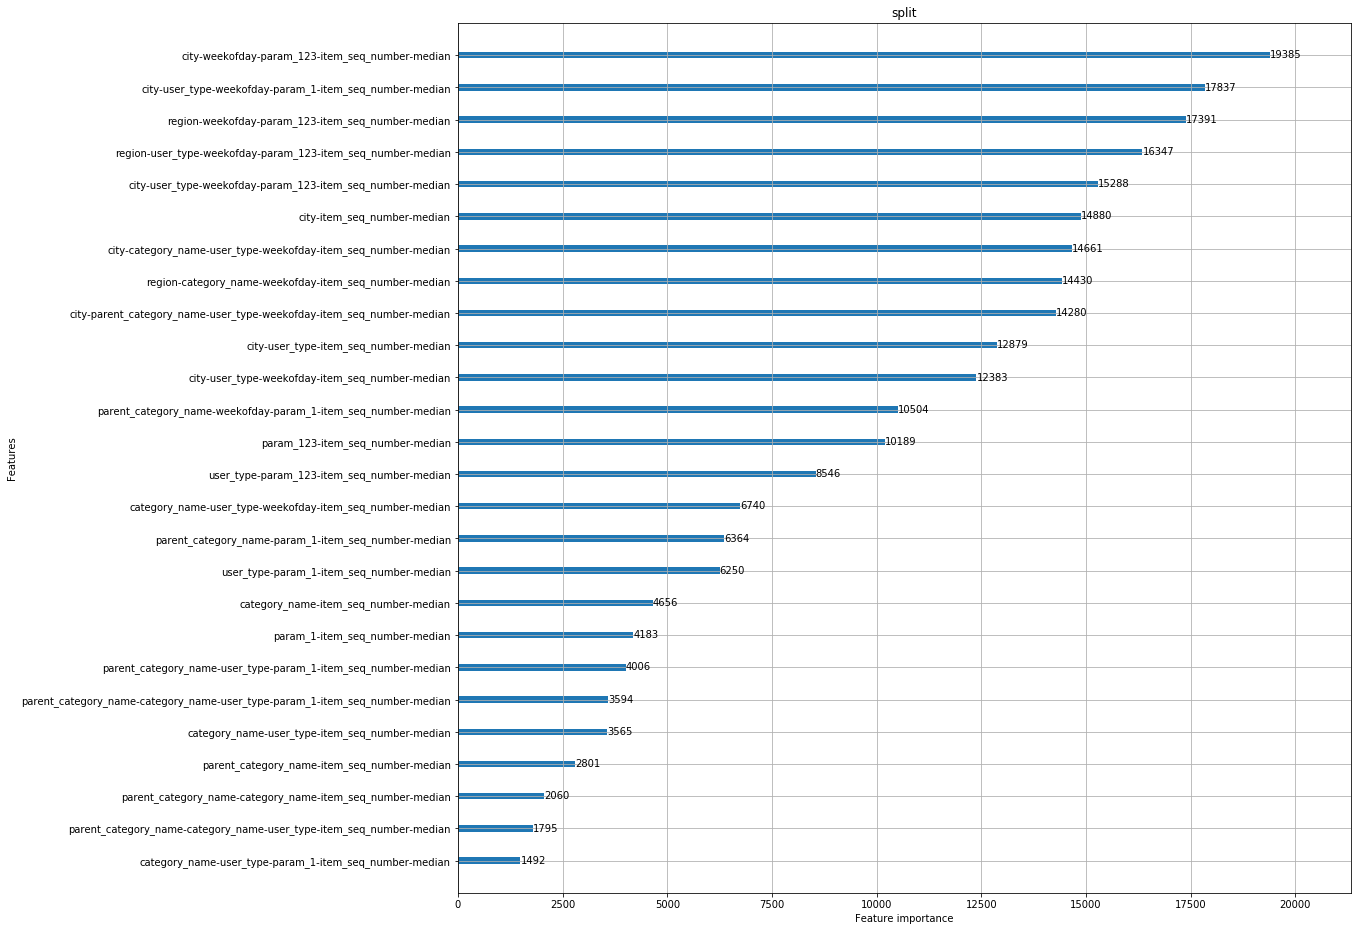

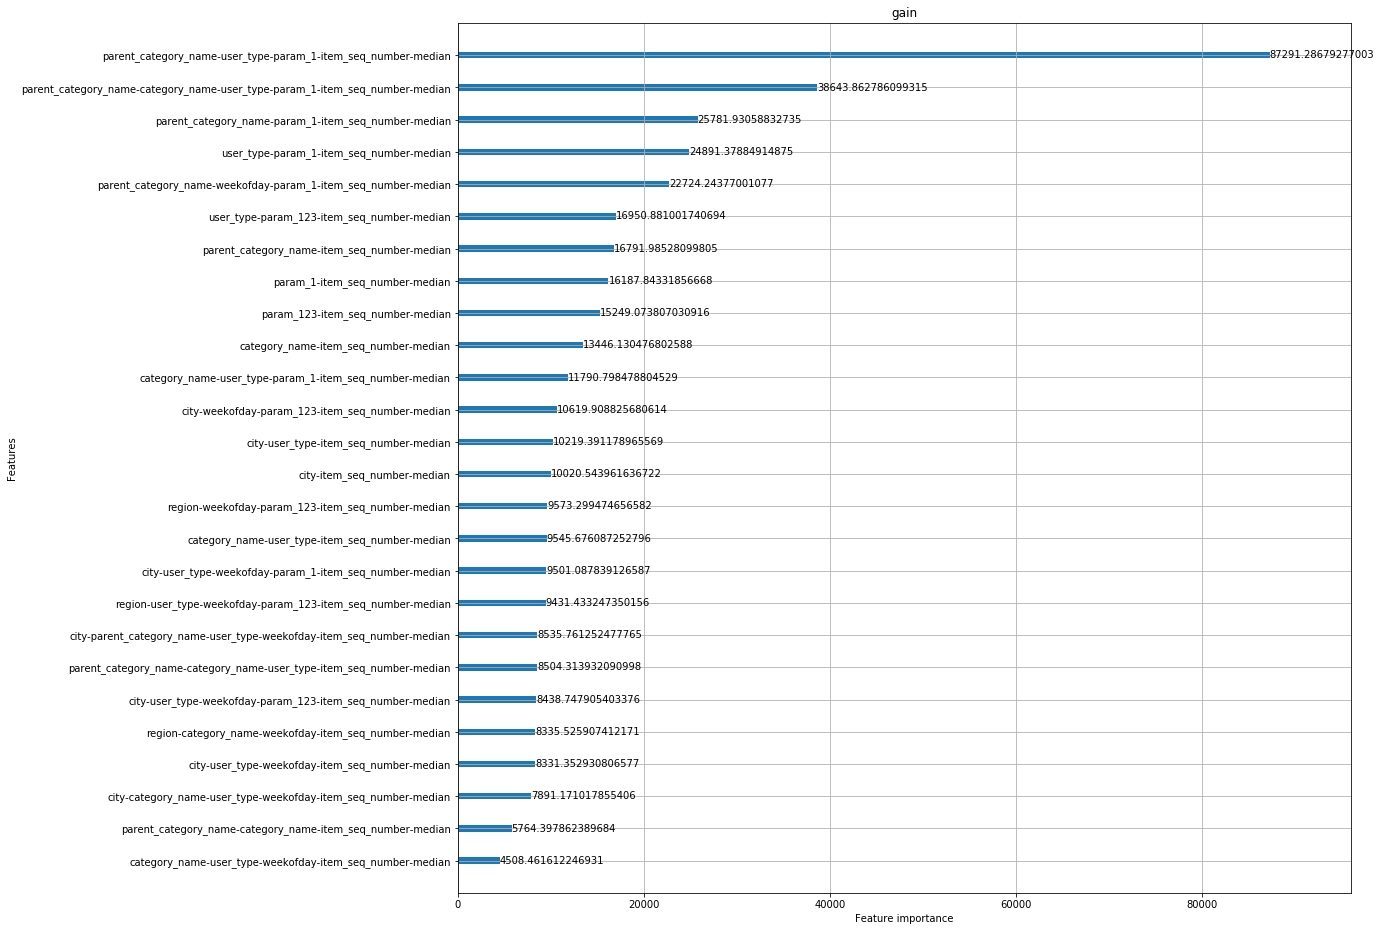

best iteration is 494
best score is 0.23278144117636357
Training until validation scores don't improve for 50 rounds.
[50]	valid's rmse: 0.239171
[100]	valid's rmse: 0.234544
[150]	valid's rmse: 0.233488
[200]	valid's rmse: 0.233188
[250]	valid's rmse: 0.233068
[300]	valid's rmse: 0.233023
[350]	valid's rmse: 0.232996
[400]	valid's rmse: 0.232985
[450]	valid's rmse: 0.23297
[500]	valid's rmse: 0.232961
Did not meet early stopping. Best iteration is:
[490]	valid's rmse: 0.232958


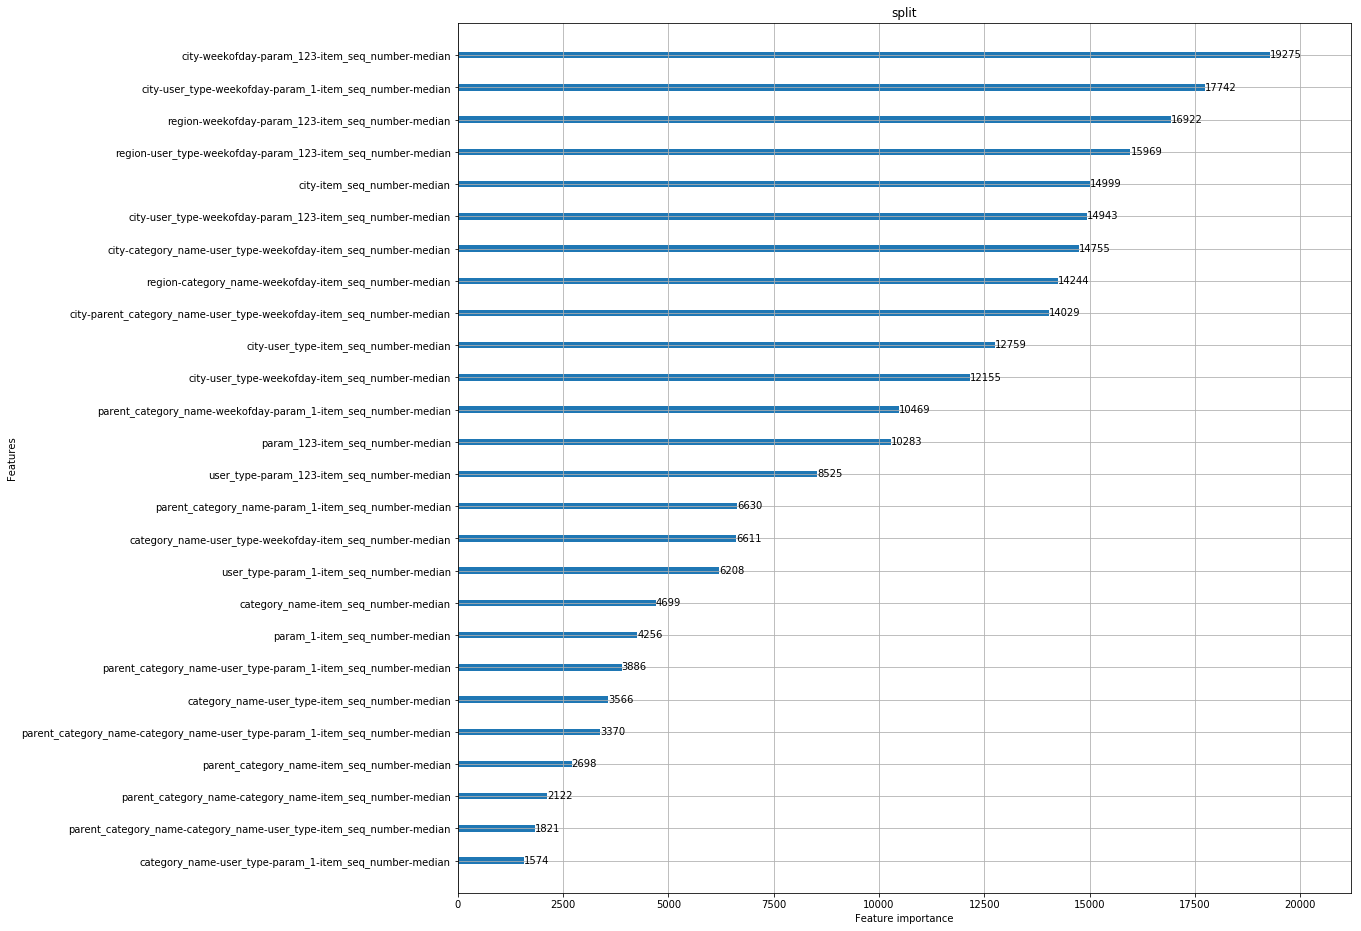

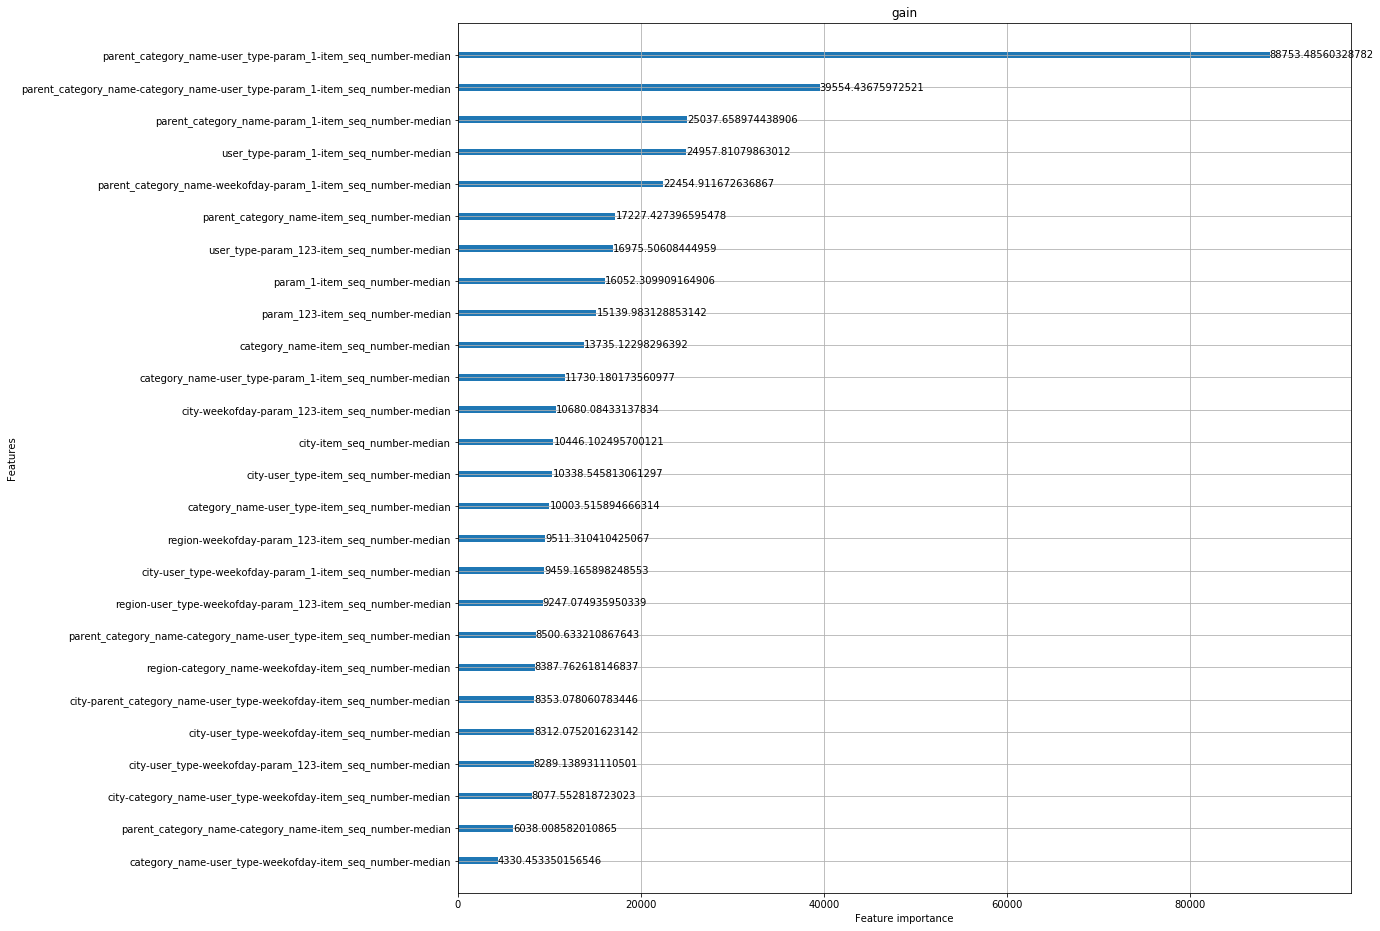

best iteration is 490
best score is 0.23295797341095334
Training until validation scores don't improve for 50 rounds.
[50]	valid's rmse: 0.240277
[100]	valid's rmse: 0.23554
[150]	valid's rmse: 0.234407
[200]	valid's rmse: 0.234069
[250]	valid's rmse: 0.233935
[300]	valid's rmse: 0.233884
[350]	valid's rmse: 0.233839
[400]	valid's rmse: 0.23381
[450]	valid's rmse: 0.233787
[500]	valid's rmse: 0.233779
Did not meet early stopping. Best iteration is:
[493]	valid's rmse: 0.233777


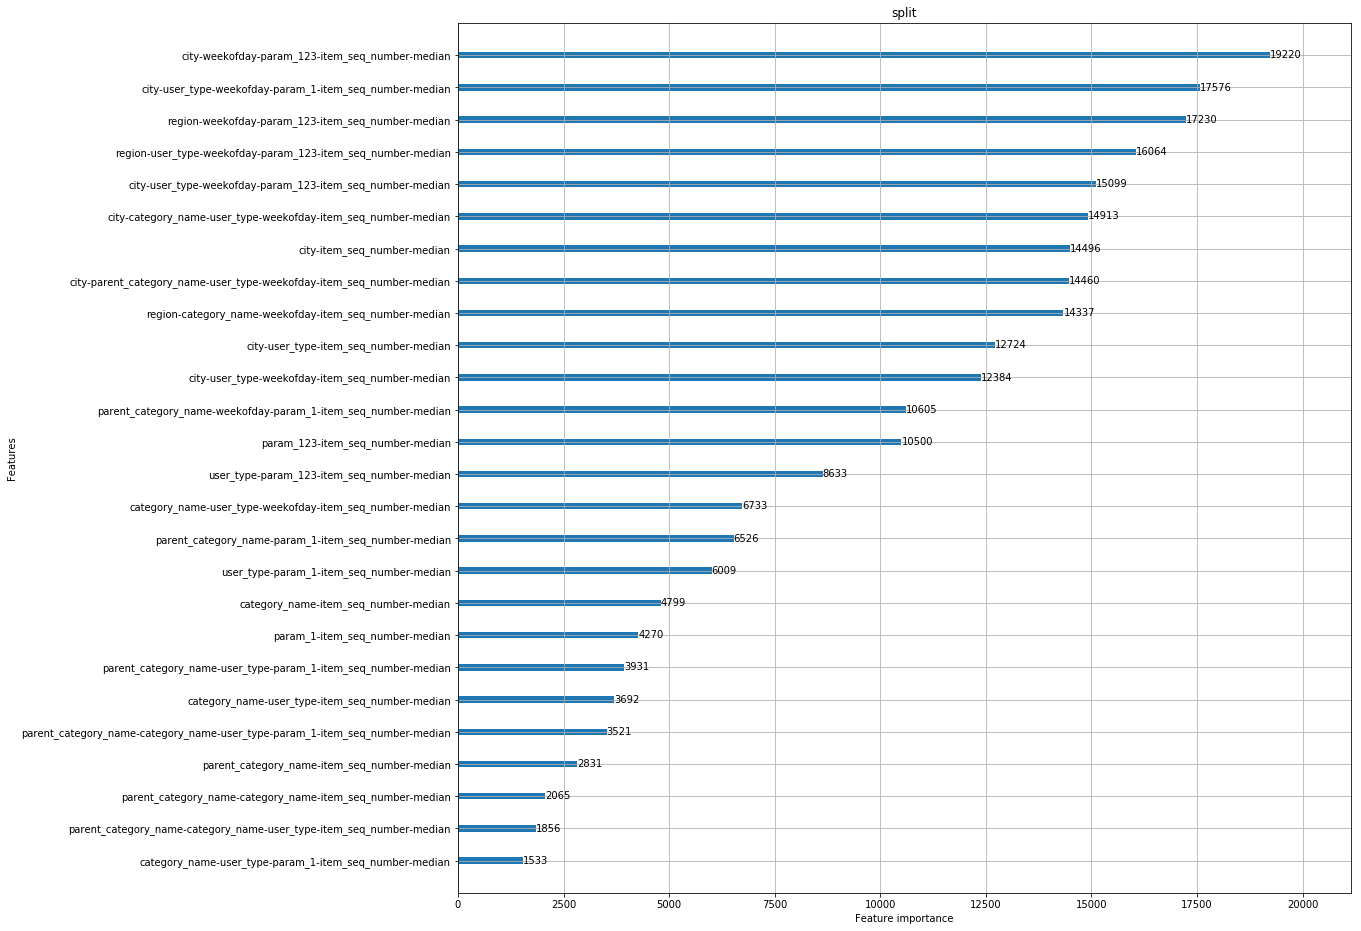

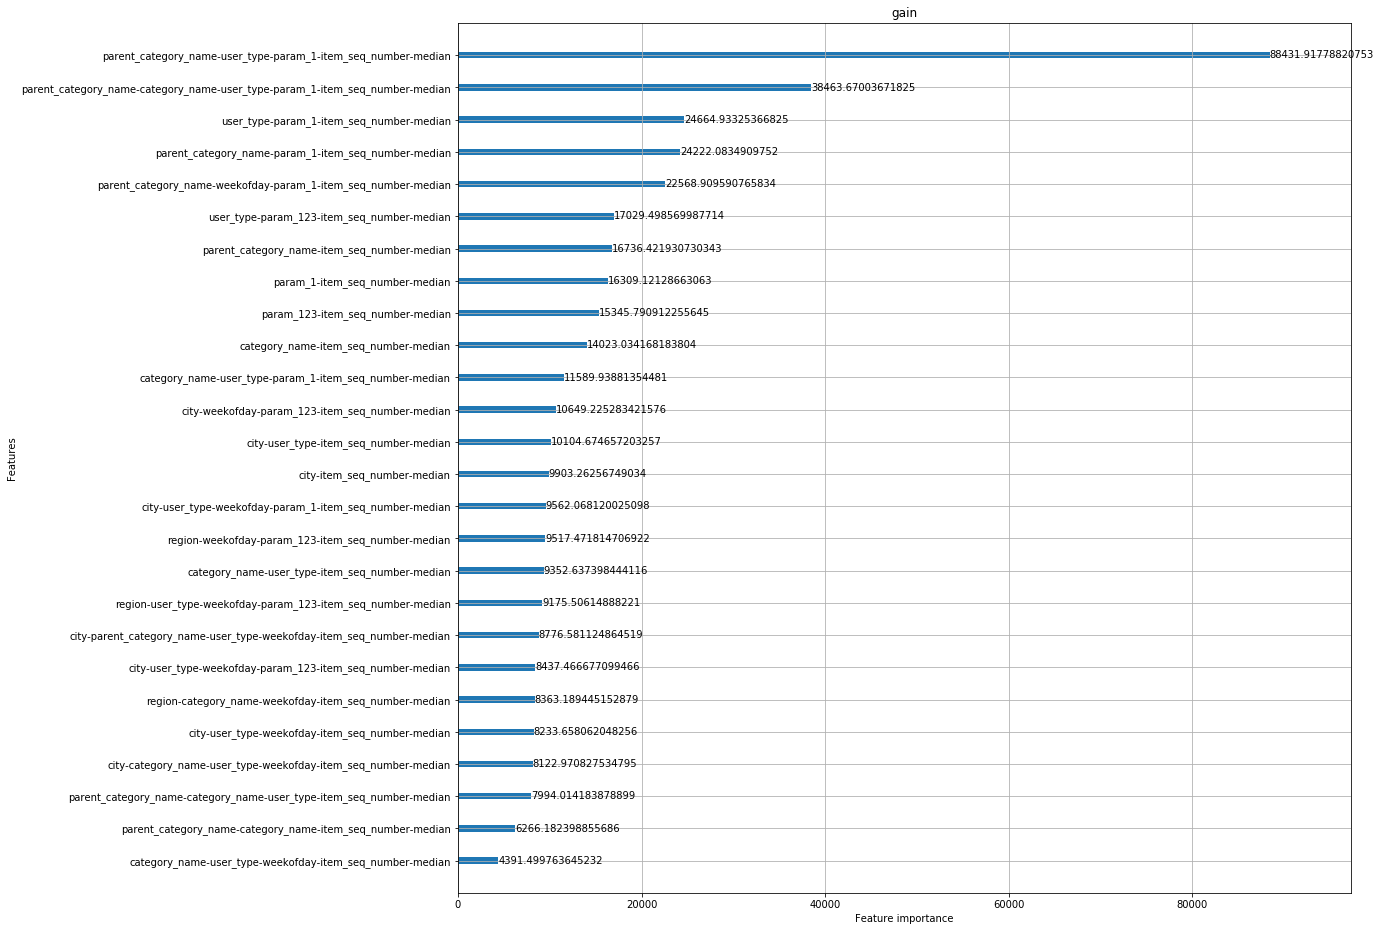

best iteration is 493
best score is 0.23377688413030845
Best iterations:
[494, 490, 493]


In [34]:
# Example For KFold
EnableSubmit = False
NFOLDS = 3
numiter = 500

train = pd.read_feather('../features/train/Agg_Itemseq_median_Golden_features_train.feather')
y = pd.read_csv('../input/train.csv', usecols=['deal_probability'])

kf = KFold(n_splits=NFOLDS)
lgb_models = []
best_iters = []
feature_imp_split = []
feature_imp_gain = []
print(train.shape)
print(y.shape)
preds = pd.DataFrame()
predictors = train.columns.tolist()

for count, indices in enumerate(kf.split(train, y)):
    train_idx = indices[0]
    valid_idx = indices[1]
    Dtrain, Dvalid = get_lgb_train(train.iloc[train_idx,:], y.iloc[train_idx,:], train.iloc[valid_idx,:], y.iloc[valid_idx,:], predictors, categorical)
    del train, y; gc.collect()
    params = {'num_leaves': 500}
    lgb_model, bestiter = get_lgb_model(Dtrain, Dvalid, param=params,numiter=numiter, isValid=True, randomseed=76)
    del Dtrain, Dvalid; gc.collect()

    if EnableSubmit == True:
        test = pd.read_feather('../')
        preds['lgb_pred_kfold_'+str(count)] = lgb_model.predict(test[predictors], num_iteration=best_iter)
        del test; gc.collect()
    
    lgb_models.append(lgb_model)
    best_iters.append(bestiter)
    fcols = lgb_model.feature_name()
    fimps = lgb_model.feature_importance(importance_type='split')
    feature_imp_split.append({fcol: fimp for fimp, fcol in zip(fimps, fcols)})
    fimps = lgb_model.feature_importance(importance_type='gain')
    feature_imp_gain.append({fcol: fimp for fimp, fcol in zip(fimps, fcols)})
    
    train = pd.read_feather('../features/train/Agg_Itemseq_median_Golden_features_train.feather')
    y = pd.read_csv('../input/train.csv', usecols=['deal_probability'])

del train, y
gc.collect()

print('Best iterations:')
print(best_iters)

if EnableSubmit == True:
    subs = pd.read_csv('../input/test.csv', usecols=['item_id'])

    pred_ensemble = np.zeros_like(preds['lgb_pred_kfold_0'].values)
    for col in preds.columns:
        pred_ensemble += preds[col].values
    pred_ensemble /= np.float(NFOLDS)
    pred_ensemble = np.clip(pred_ensemble, 0, 1)
    subs['deal_probability'] = pred_ensemble.flatten()

    datetime = dt.now().strftime('%Y_%m%d_%H%M_%S')
    fileprefix = '../subs/lightgbm_kfold_ensemble_'
    filename = fileprefix+datetime+'.csv.gz'
    subs.to_csv(filename, index=False, float_format='%.9f', compression='gzip')

    del subs; gc.collect()


['price', 'image_top_1']
(1275576, 2)
(227848, 2)


C:\Users\osk\Anaconda3\envs\InqueryAnalysis\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds.
[50]	valid's rmse: 0.249281
[100]	valid's rmse: 0.245912
Did not meet early stopping. Best iteration is:
[100]	valid's rmse: 0.245912


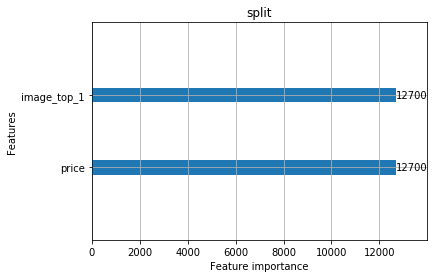

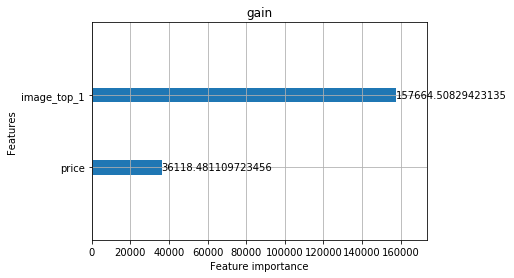

best iteration is 100
best score is 0.24591241735375752
Best iterations:
[100]
Feature Importtance Split
[{'price': 12700, 'image_top_1': 12700}]
Feature Importtance Gain
[{'price': 36118.481109723456, 'image_top_1': 157664.50829423135}]
done


In [30]:
# Debug For Avito2018
train = pd.read_csv('../input/train.csv', usecols=['price', 'image_top_1', 'activation_date'], parse_dates=['activation_date'],
                    dtype={'price': 'float32', 'image_top_1': 'float32'})
train = train.fillna(0)
y = pd.read_csv('../input/train.csv', usecols=['deal_probability'])

training_index   = train.loc[train.activation_date <= pd.to_datetime('2017-03-26')].index
validation_index = train.loc[train.activation_date >= pd.to_datetime('2017-03-27')].index
split_indices = [[training_index, validation_index]]
train.drop(['activation_date'], axis=1, inplace=True)
gc.collect()

lgb_models = []
best_iters = []
feature_imp_split = []
feature_imp_gain = []
preds = pd.DataFrame()
predictors = train.columns.tolist()

print(predictors)
for count, indices in enumerate(split_indices):
    train_idx = indices[0]
    valid_idx = indices[1]
    Dtrain, Dvalid = get_lgb_train(train.iloc[train_idx,:], y.iloc[train_idx,:], train.iloc[valid_idx,:], y.iloc[valid_idx,:], predictors, categorical)
    del train, y; gc.collect()
    print(Dtrain.data.shape)
    print(Dvalid.data.shape)
    lgb_model, best_iter = get_lgb_model(Dtrain, Dvalid, numiter=100, isValid=True, randomseed=123)
    del Dtrain, Dvalid; gc.collect()

    test = pd.read_csv('../input/test.csv', usecols=['price', 'image_top_1'], dtype={'price': 'float32', 'image_top_1': 'float32'})
    preds['lgb_pred_kfold_'+str(count)] = lgb_model.predict(test[predictors], num_iteration=best_iter)
    del test; gc.collect()
    
    lgb_models.append(lgb_model)
    best_iters.append(best_iter)
    fcols = lgb_model.feature_name()
    fimps = lgb_model.feature_importance(importance_type='split')
    feature_imp_split.append({fcol: fimp for fimp, fcol in zip(fimps, fcols)})
    fimps = lgb_model.feature_importance(importance_type='gain')
    feature_imp_gain.append({fcol: fimp for fimp, fcol in zip(fimps, fcols)})
    
    train = pd.read_csv('../input/train.csv', usecols=['price', 'image_top_1'], dtype={'price': 'float32', 'image_top_1': 'float32'})
    train = train.fillna(0)
    y = pd.read_csv('../input/train.csv', usecols=['deal_probability'])

del train, y
gc.collect()

print('Best iterations:')
print(best_iters)
print('Feature Importtance Split')
print(feature_imp_split)
print('Feature Importtance Gain')
print(feature_imp_gain)

subs = pd.read_csv('../input/test.csv', usecols=['item_id'])

pred_ensemble = np.zeros_like(preds['lgb_pred_kfold_0'].values)
for col in preds.columns:
    pred_ensemble += preds[col].values
pred_ensemble /= np.float(NFOLDS)
pred_ensemble = np.clip(pred_ensemble, 0, 1)
subs['deal_probability'] = pred_ensemble.flatten()

datetime = dt.now().strftime('%Y_%m%d_%H%M_%S')
fileprefix = '../subs/lightgbm_kfold_ensemble_'
filename = fileprefix+datetime+'.csv.gz'
subs.to_csv(filename, index=False, float_format='%.9f', compression='gzip',)
with open(fileprefix+datetime+'_fimp_split.pickle', 'wb') as f:
    pickle.dump(feature_imp_split, f)
with open(fileprefix+datetime+'_fimp_gain.pickle', 'wb') as f:
    pickle.dump(feature_imp_gain, f)
    
del subs, lgb_models, best_iters; gc.collect()

print('done')

['price', 'image_top_1']
Training until validation scores don't improve for 50 rounds.


C:\Users\osk\Anaconda3\envs\InqueryAnalysis\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[50]	valid's rmse: 0.252395
[100]	valid's rmse: 0.249167
[150]	valid's rmse: 0.247827
[200]	valid's rmse: 0.247183
Did not meet early stopping. Best iteration is:
[200]	valid's rmse: 0.247183


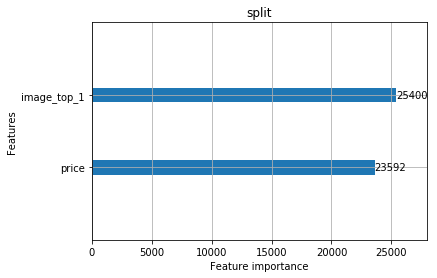

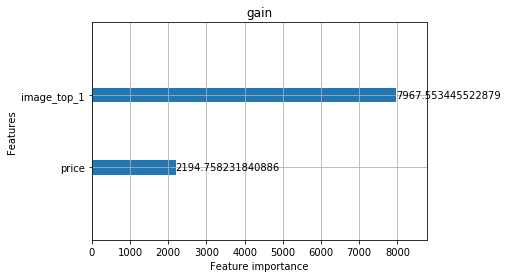

best iteration is 200
best score is 0.24718323691465693
Training until validation scores don't improve for 50 rounds.
[50]	valid's rmse: 0.25197
[100]	valid's rmse: 0.248738
[150]	valid's rmse: 0.247407
[200]	valid's rmse: 0.246756
Did not meet early stopping. Best iteration is:
[200]	valid's rmse: 0.246756


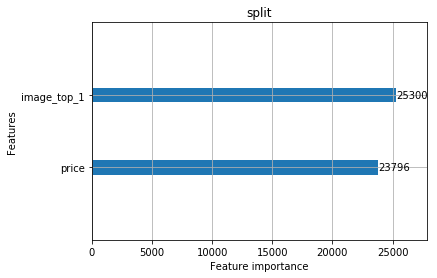

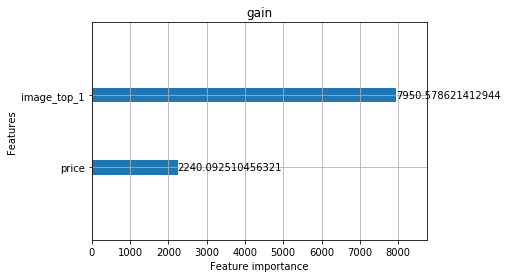

best iteration is 200
best score is 0.24675563269041953
Best iterations:
[200, 200]
Best iterations:
[200, 200]
Feature Importtance Split
[{'price': 23592, 'image_top_1': 25400}, {'price': 23796, 'image_top_1': 25300}]
Feature Importtance Gain
[{'price': 2194.758231840886, 'image_top_1': 7967.553445522879}, {'price': 2240.092510456321, 'image_top_1': 7950.578621412944}]
done


In [31]:
# Debug
train = pd.read_csv('../input/train.csv', usecols=['price', 'image_top_1'], nrows=100000, dtype={'price': 'float32', 'image_top_1': 'float32'})
train = train.fillna(0)
y = pd.read_csv('../input/train.csv', usecols=['deal_probability'], nrows=100000)
predictors = train.columns.tolist()

skf = KFold(n_splits=2)
lgb_models = []
best_iters = []
feature_imp_split = []
feature_imp_gain = []
preds = pd.DataFrame()
count = 0

print(predictors)
for count, indices in enumerate(skf.split(train, y)):
    train_idx = indices[0]
    valid_idx = indices[1]
    Dtrain, Dvalid = get_lgb_train(train.iloc[train_idx,:], y.iloc[train_idx,:], train.iloc[valid_idx,:], y.iloc[valid_idx,:], predictors, categorical)
    del train, y; gc.collect()
    lgb_model, best_iter = get_lgb_model(Dtrain, Dvalid, numiter=200, isValid=True, randomseed=34+count)
    del Dtrain, Dvalid; gc.collect()

    test = pd.read_csv('../input/test.csv', usecols=['price', 'image_top_1'], nrows=100000, dtype={'price': 'float32', 'image_top_1': 'float32'})
    preds['lgb_pred_kfold_'+str(count)] = lgb_model.predict(test[predictors], num_iteration=best_iter)
    del test; gc.collect()
    
    lgb_models.append(lgb_model)
    best_iters.append(best_iter)
    fcols = lgb_model.feature_name()
    fimps = lgb_model.feature_importance(importance_type='split')
    feature_imp_split.append({fcol: fimp for fimp, fcol in zip(fimps, fcols)})
    fimps = lgb_model.feature_importance(importance_type='gain')
    feature_imp_gain.append({fcol: fimp for fimp, fcol in zip(fimps, fcols)})

    train = pd.read_csv('../input/train.csv', usecols=['price', 'image_top_1'], nrows=100000, dtype={'price': np.float32, 'image_top_1': np.float32})
    train.fillna(0)
    y = pd.read_csv('../input/train.csv', usecols=['deal_probability'], nrows=100000)

del train, y
gc.collect()

print('Best iterations:')
print(best_iters)
print('Feature Importtance Split')
print(feature_imp_split)
print('Feature Importtance Gain')
print(feature_imp_gain)

subs = pd.read_csv('../input/test.csv', usecols=['item_id'], nrows=100000)

pred_ensemble = np.zeros_like(preds['lgb_pred_kfold_0'].values)
for col in preds.columns:
    pred_ensemble += preds[col].values
pred_ensemble /= np.float(NFOLDS)
pred_ensemble = np.clip(pred_ensemble, 0, 1)
subs['deal_probability'] = pred_ensemble.flatten()

datetime = dt.now().strftime('%Y_%m%d_%H%M_%S')
fileprefix = '../subs/lightgbm_kfold_ensemble_'
filename = fileprefix+datetime+'.csv.gz'
subs.to_csv(filename, index=False, float_format='%.9f', compression='gzip')
with open(fileprefix+datetime+'_fimp_split.pickle', 'wb') as f:
    pickle.dump(feature_imp_split, f)
with open(fileprefix+datetime+'_fimp_gain.pickle', 'wb') as f:
    pickle.dump(feature_imp_gain, f)


del subs, lgb_models, best_iters; gc.collect()

print('done')

C:\Users\osk\Anaconda3\envs\InqueryAnalysis\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[100]	valid's rmse: 0.0955291
[200]	valid's rmse: 0.0931288
[300]	valid's rmse: 0.0910921
[400]	valid's rmse: 0.0892808
[500]	valid's rmse: 0.0880774


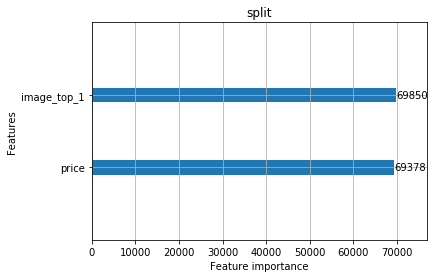

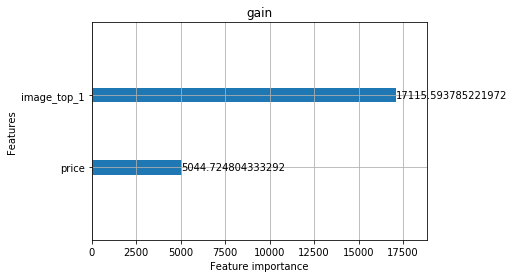

best iteration is 0
Feature Importtance Split
[{'price': 69378, 'image_top_1': 69850}]
Feature Importtance Gain
[{'price': 5044.724804333292, 'image_top_1': 17115.593785221972}]


37

In [34]:
# Debug
# Example For whole traindata
bestiter = 500
train = pd.read_csv('../input/train.csv', usecols=['price', 'image_top_1'], nrows=100000, dtype={'price': 'float32', 'image_top_1': 'float32'})
train = train.fillna(0)
y = pd.read_csv('../input/train.csv', usecols=['deal_probability'], nrows=100000)
predictors = train.columns.tolist()

Dtrain, Dvalid = get_lgb_train(train, y, train.iloc[:2, :], y.iloc[:2, :], predictors, categorical)
del train, y; gc.collect()
numiter = np.uint(bestiter*1.1)
lgb_model, best_iter = get_lgb_model(Dtrain, Dvalid, numiter=numiter, isValid=False, randomseed=87)
del Dtrain; gc.collect()

feature_imp_split = []
feature_imp_gain = []
fcols = lgb_model.feature_name()
fimps = lgb_model.feature_importance(importance_type='split')
feature_imp_split.append({fcol: fimp for fimp, fcol in zip(fimps, fcols)})
fimps = lgb_model.feature_importance(importance_type='gain')
feature_imp_gain.append({fcol: fimp for fimp, fcol in zip(fimps, fcols)})

print('Feature Importtance Split')
print(feature_imp_split)
print('Feature Importtance Gain')
print(feature_imp_gain)

subs = pd.read_csv('../input/test.csv', usecols=['item_id'], nrows=100000)
test = pd.read_csv('../input/test.csv', usecols=['price', 'image_top_1'], nrows=100000, dtype={'price': 'float32', 'image_top_1': 'float32'})
subs['deal_probability'] = lgb_model.predict(test[predictors], num_iteration=best_iter)

datetime = dt.now().strftime('%Y_%m%d_%H%M_%S')
fileprefix = '../subs/lightgbm_kfold_ensemble_'
filename = fileprefix+datetime+'.csv.gz'
subs.to_csv(filename, index=False, float_format='%.9f', compression='gzip')
with open(fileprefix+datetime+'_fimp_split.pickle', 'wb') as f:
    pickle.dump(feature_imp_split, f)
with open(fileprefix+datetime+'_fimp_gain.pickle', 'wb') as f:
    pickle.dump(feature_imp_gain, f)

del subs, test; gc.collect()